In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
include("spiking.jl")

train_to_phase (generic function with 1 method)

In [4]:
model = Chain(PhasorDense(1024 => 32), )

Chain(
  PhasorDense(1024 => 32),              # 32_800 parameters
) 

In [5]:
x = random_symbols((100, 1024))

100×1024 Matrix{Float64}:
 -0.275121   -0.620393    0.63179     …   0.14843     0.349061   -0.259674
  0.990253   -0.0318725   0.612281       -0.26023    -0.507605    0.78995
  0.287446    0.224044   -0.872646        0.389798    0.0570375  -0.725647
  0.147585   -0.282779   -0.91912         0.0221428   0.989342   -0.270382
 -0.182581    0.722893   -0.41053         0.526516   -0.699096   -0.0843204
  0.200983   -0.0215745   0.844693    …   0.624898   -0.308758    0.0484639
  0.775203   -0.0793736   0.105409        0.65043    -0.119144   -0.111457
 -0.367722    0.585011   -0.0719043       0.350602    0.797443    0.742025
  0.647213   -0.78323    -0.93051         0.198114    0.64507    -0.566043
 -0.357311    0.265115    0.00190151      0.995504    0.955525    0.0625414
  0.898865    0.401413    0.922956    …  -0.556659    0.86422    -0.998333
 -0.947062    0.141903   -0.303595        0.308848   -0.384009   -0.192947
  0.624437    0.490846   -0.790276        0.619889   -0.815992   -0.2403

In [6]:
x |> size

(100, 1024)

In [7]:
y = model(x)

100×32 Matrix{Float64}:
 -0.471636   -0.0861388    0.538052    …   0.341745     0.265144
 -0.309858   -0.935988     0.0329073       0.451286    -0.813399
  0.368239    0.149852     0.520763       -0.278071     0.573579
 -0.231085   -0.794279    -0.498795        0.340799    -0.205835
  0.463458   -0.242518     0.514357       -0.0790153    0.164119
 -0.0841194   0.89893     -0.25043     …  -0.249751    -0.072968
 -0.16663    -0.999716     0.366835       -0.526186    -0.0696956
 -0.012341    0.520373     0.283814        0.122776    -0.0550592
  0.381033   -0.0621522    0.428548       -0.401863    -0.00906353
  0.107264    0.10617      0.882358        0.0255976    0.182873
 -0.041167   -0.964841     0.68206     …   0.359074    -0.292386
  0.29029     0.0760365    0.296494        0.25481     -0.115544
  0.126021    0.551473    -0.215618       -0.45653     -0.614917
  ⋮                                    ⋱   ⋮           
  0.403968    0.253246     0.831243       -0.231531    -0.083144
  0.78

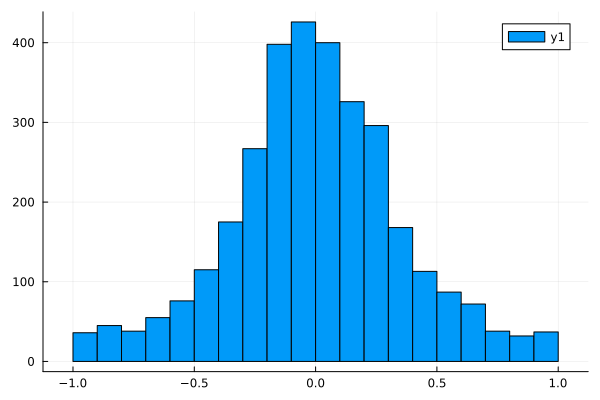

In [8]:
histogram(y |> vec)

In [9]:
function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    @info "Getting and transforming data"

    ## Load dataset
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    ## Reshape input data to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    ## One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    ## Create two DataLoader objects (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_loader, test_loader
end

getdata (generic function with 1 method)

In [10]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain( PhasorDense(prod(imgsize) => 32),
                  PhasorDense(32 => nclasses))
end

build_model (generic function with 1 method)

In [11]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [12]:
train_loader, test_loader = getdata(Args())

[ Info: Getting and transforming data


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [13]:
x, y = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[1 0 … 1 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0])

In [14]:
x

784×256 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [15]:
y

10×256 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [16]:
phasor_model = build_model()

Chain(
  PhasorDense(784 => 32),               # 25_120 parameters
  PhasorDense(32 => 10),                # 330 parameters
)                   # Total: 4 arrays, 25_450 parameters, 199.078 KiB.

In [17]:
pc = phasor_model(x')

256×10 Matrix{Float32}:
 -0.63278      0.0943493    0.306397   …  -0.0615367  -0.487201
 -0.212174     0.348914     0.103598       0.916027    0.0822846
  0.115455     0.129784     0.136181      -0.0740912  -0.304705
 -0.220895     0.155833     0.187918      -0.0357398  -0.134221
 -0.0576868   -0.0102948   -0.076767       0.0752527  -0.0323664
  0.369439     0.150236     0.205451   …  -0.101741   -0.266074
  0.957904    -0.0811407   -0.0595317     -0.100928    0.747362
 -0.0827735    0.364861    -0.0680614      0.389904    0.0193461
 -0.247229     0.188634    -0.759041      -0.138696   -0.523819
 -0.856282     0.0786206    0.103966      -0.0607155  -0.594693
  0.00275819  -0.0704705    0.0456055  …  -0.0477612  -0.0798864
 -0.422037     0.384181     0.210356       0.866087   -0.853442
  0.880698    -0.0825068   -0.050782       0.346897    0.874141
  ⋮                                    ⋱              
 -0.878303     0.225986    -0.265084       0.0402594   0.00246981
 -0.857137     0.18

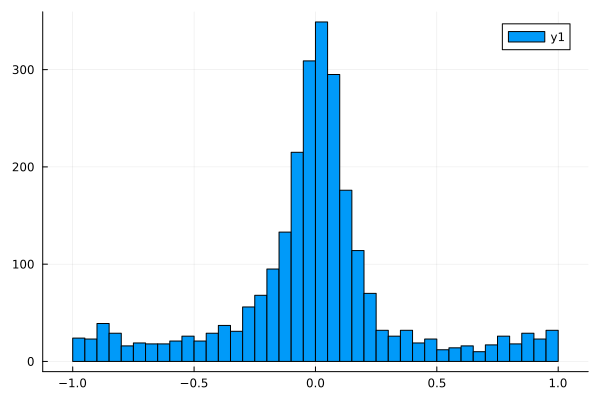

In [18]:
histogram(pc |> vec)

In [19]:
sa = default_spk_args()

SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05)

In [20]:
xt = phase_to_train(x', sa, 3, 0.0)

SpikeTrain([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  200695, 200696, 200697, 200698, 200699, 200700, 200701, 200702, 200703, 200704], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], (256, 784), 0.0)

In [21]:
xt.shape

(256, 784)

In [22]:
call = SpikingCall(xt, sa, (0.0, 10.0))

SpikingCall(SpikeTrain([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  200695, 200696, 200697, 200698, 200699, 200700, 200701, 200702, 200703, 200704], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], (256, 784), 0.0), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0))

In [27]:
CartesianIndex((4,1)

LoadError: syntax: incomplete: premature end of input

In [29]:
CartesianIndex.([4,3,1], [1,1,1])

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(4, 1)
 CartesianIndex(3, 1)
 CartesianIndex(1, 1)

In [ ]:
#TODO - check code works with cartesianindex added into spiketrain

In [24]:
out1 = phasor_model[1](call)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mTuple{Vector{Int64}, Vector{Int64}}[39m[0m to an object of type 
[0m  [91mVector{<:Int64}[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Union{Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}} where T, Union{Base.LogicalIndex{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, Base.ReinterpretArray{T, N, <:Any, <:Union{SubArray{<:Any, <:Any, var"#s14"}, var"#s14"}} where var"#s14"<:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}, Base.ReshapedArray{T, N, <:Union{Base.ReinterpretArray{<:Any, <:Any, <:Any, <:Union{SubArray{<:Any, <:Any, var"#s15"}, var"#s15"}}, SubArray{<:Any, <:Any, var"#s15"}, var"#s15"}} where var"#s15"<:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}, SubArray{T, N, <:Union{Base.ReinterpretArray{<:Any, <:Any, <:Any, <:Union{SubArray{<:Any, <:Any, var"#s16"}, var"#s16"}}, Base.ReshapedArray{<:Any, <:Any, <:Union{Base.ReinterpretArray{<:Any, <:Any, <:Any, <:Union{SubArray{<:Any, <:Any, var"#s16"}, var"#s16"}}, SubArray{<:Any, <:Any, var"#s16"}, var"#s16"}}, var"#s16"}} where var"#s16"<:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}, LinearAlgebra.Adjoint{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.Diagonal{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.LowerTriangular{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.Symmetric{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.Transpose{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.Tridiagonal{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.UnitLowerTriangular{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.UnitUpperTriangular{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, LinearAlgebra.UpperTriangular{T, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}, PermutedDimsArray{T, N, <:Any, <:Any, <:Union{NNlib.BatchedAdjoint{T, <:CUDA.CuArray{T}}, NNlib.BatchedTranspose{T, <:CUDA.CuArray{T}}}}} where {T, N}}[39m) where T<:Array at ~/.julia/packages/NNlibCUDA/C6t0p/src/batchedadjtrans.jl:15
[0m  convert(::Type{T}, [91m::LinearAlgebra.Factorization[39m) where T<:AbstractArray at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/LinearAlgebra/src/factorization.jl:58
[0m  convert(::Type{T}, [91m::AbstractArray[39m) where T<:Array at array.jl:617
[0m  ...

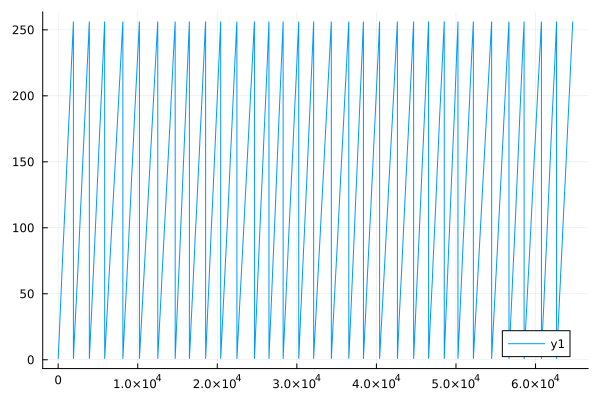

In [61]:
plot(out1.input.indices)

In [27]:
output = phasor_model(call)

SpikingCall(SpikeTrain([1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  255, 256, 256, 256, 256, 256, 256, 256, 256, 256], [2.4699999999999913, 3.45999999999997, 4.399999999999951, 5.409999999999929, 6.399999999999908, 7.419999999999886, 8.429999999999865, 9.439999999999843, 2.4499999999999917, 3.4399999999999706  …  9.419999999999844, 1.0200000000000007, 2.4099999999999926, 3.3899999999999717, 4.379999999999951, 5.34999999999993, 6.349999999999909, 7.369999999999887, 8.389999999999866, 9.409999999999844], (256, Base.OneTo(10)), 0.5), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0))

In [44]:
ot = output.input

SpikeTrain([1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  255, 256, 256, 256, 256, 256, 256, 256, 256, 256], [2.4699999999999913, 3.45999999999997, 4.399999999999951, 5.409999999999929, 6.399999999999908, 7.419999999999886, 8.429999999999865, 9.439999999999843, 2.4499999999999917, 3.4399999999999706  …  9.419999999999844, 1.0200000000000007, 2.4099999999999926, 3.3899999999999717, 4.379999999999951, 5.34999999999993, 6.349999999999909, 7.369999999999887, 8.389999999999866, 9.409999999999844], (256, Base.OneTo(10)), 0.5)

In [47]:
length(ot.indices) / (256 * 10)

7.791015625

In [50]:
phases = time_to_phase(ot.times, 1.0, ot.offset)

19945-element Vector{Float64}:
 0.9399999999999826
 0.9199999999999404
 0.7999999999999012
 0.8199999999998582
 0.799999999999816
 0.8399999999997725
 0.8599999999997294
 0.8799999999996864
 0.8999999999999835
 0.8799999999999413
 0.8199999999999008
 0.7599999999998595
 0.7399999999998172
 ⋮
 0.7999999999997733
 0.8199999999997303
 0.8399999999996872
 0.04000000000000137
 0.8199999999999852
 0.7799999999999434
 0.7599999999999021
 0.6999999999998607
 0.6999999999998181
 0.7399999999997746
 0.7799999999997311
 0.8199999999996876

In [51]:
ot.indices

19945-element Vector{Int64}:
   1
   1
   1
   1
   1
   1
   1
   1
   2
   2
   2
   2
   2
   ⋮
 255
 255
 255
 256
 256
 256
 256
 256
 256
 256
 256
 256

In [29]:
function train_to_phase(train::SpikeTrain, spk_args::SpikingArgs)
    if length(train.times) == 0
        return missing
    end

    phases_vec = time_to_phase(train.times, spk_args.t_period, train.offset)
    n_cycles = maximum(train.times) ÷ spk_args.t_period + 1
    cycle = floor.(Int, train.times .÷ spk_args.t_period .+ 1)
    phases = [NaN .* zeros(n_cycles, train.shape...) for i in 1:n_cycles]

    for i in eachindex(phases_vec)
        phases[cycle[i]][train.indices[i]] = phases_vec[i]
    end

    #stack the arrays to cycle, batch, neuron
    phases = mapreduce(x->reshape(x, 1, train.shape...), vcat, phases)
    return phases

end

train_to_phase (generic function with 1 method)

In [30]:
xs = train_to_phase(output.input, output.spk_args)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN     NaN
 NaN     NaN     NaN     NaN       0.9      NaN       0.6   NaN       0.04
   0.94    0.9     0.86    0.76    0.86       0.82    0.66    0.82    0.82
   0.92    0.88    0.84    0.76    0.84       0.82    0.7     0.8     0.78
   0.8     0.82    0.88    0.72    0.82       0.88    0.78    0.78    0.76
   0.8     0.76    0.92    0.72    0.8   …    0.88    0.8     0.78    0.7
   0.8     0.74    0.96    0.72    0.78       0.88    0.8     0.78    0.7
   0.84    0.76    0.92    0.74    0.8        0.9     0.84    0.8     0.74
   0.86    0.78    0.96    0.8     0.84       0.92    0.86    0.82    0.78
   0.88    0.82    0.96    0.84    0.86       0.92    0.88    0.84    0.82

[:, :, 2] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     N

In [20]:
phasor_model[1].weight |> size

(32, 784)

In [21]:
phasor_model[1].bias |> size

(32,)

In [19]:
function quadrature_loss(phases::AbstractMatrix, truth::AbstractMatrix)
    targets = 0.5 .* truth
    sim = similarity(phases, targets)
    return 1.0 .- sim
end


quadrature_loss (generic function with 1 method)

In [20]:
function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    predictions = getindex.(argmin(abs.(phases .- 0.5), dims=2), 2)
    labels = getindex.(findall(truth), 1)
    return predictions .== labels
end

accuracy_quadrature (generic function with 1 method)

In [21]:
mean(accuracy_quadrature(pc, y))

LoadError: UndefVarError: pc not defined

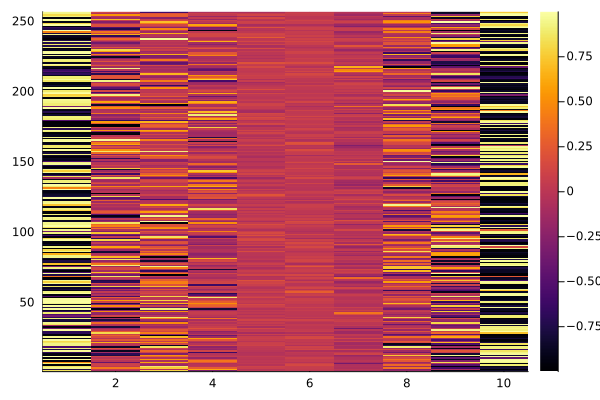

In [21]:
heatmap(pc)

In [22]:
function loss_and_accuracy(data_loader, model)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x')
        
        ls += sum(quadrature_loss(ŷ, y'))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end

loss_and_accuracy (generic function with 1 method)

In [23]:
loss_and_accuracy(test_loader, phasor_model)

(0.6926817312517211, 0.0899)

In [24]:
using Zygote: withgradient

In [25]:
function train(model; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    # if CUDA.functional() && args.use_cuda
    #     @info "Training on CUDA GPU"
    #     CUDA.allowscalar(false)
    #     device = gpu
    # else
        @info "Training on CPU"
        device = cpu
    # end

    ## Create test and train dataloaders
    train_loader, test_loader = getdata(args)

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt = Flux.setup(Adam(args.η), model)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        for (x, y) in train_loader
            x, y = transpose(device(x)), transpose(device(y)) ## transfer data to device
            loss, gs = withgradient(m -> mean(quadrature_loss(m(x), y)), model) ## compute gradient of the loss
            append!(losses, loss)
            Flux.Optimise.update!(opt, model, gs[1]) ## update parameters
        end

        ## Report on train and test
        train_loss, train_acc = loss_and_accuracy(train_loader, model)
        test_loss, test_acc = loss_and_accuracy(test_loader, model)
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end

    return losses
end

train (generic function with 1 method)

In [26]:
opt = Flux.setup(Adam(3e-4), phasor_model)

(layers = ((weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], (0.9, 0.

In [27]:
gs = gradient(m -> mean(quadrature_loss(m(xt), yt)), phasor_model)

UndefVarError: UndefVarError: xt not defined

In [28]:
gs[1]

UndefVarError: UndefVarError: gs not defined

In [29]:
Flux.Optimise.update!(opt, phasor_model, gs[1])

UndefVarError: UndefVarError: gs not defined

In [31]:
loss_and_accuracy(train_loader, phasor_model)

(0.6914549317963006, 0.0887)

In [32]:
l2, l3 = getdata(Args())

┌ Info: Getting and transforming data
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:4


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [33]:
loss_and_accuracy(l2, phasor_model)

(0.6914549317963002, 0.0887)

In [34]:
loss_and_accuracy(l3, phasor_model)

(0.6926817312517211, 0.0899)

In [35]:
l =train(phasor_model)

┌ Info: Training on CPU
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:9
┌ Info: Getting and transforming data
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:4


┌ Info: Constructing model and starting training
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:16


Epoch=1
  train_loss = 0.06023967903066517, train_accuracy = 0.0017666666666666666
  test_loss = 0.05972832147418019, test_accuracy = 0.0012


Epoch=2
  train_loss = 0.037918801785480134, train_accuracy = 0.0021333333333333334
  test_loss = 0.03734057473199118, test_accuracy = 0.0011


Epoch=3
  train_loss = 0.029081343898066814, train_accuracy = 0.0022166666666666667
  test_loss = 0.028398884737462368, test_accuracy = 0.0016


Epoch=4
  train_loss = 0.024968155589232946, train_accuracy = 0.0017166666666666667
  test_loss = 0.024422428996794157, test_accuracy = 0.0013


Epoch=5
  train_loss = 0.022357217671258513, train_accuracy = 0.00185
  test_loss = 0.02196901775859751, test_accuracy = 0.0015


Epoch=6
  train_loss = 0.0205187494413267, train_accuracy = 0.00185
  test_loss = 0.020156398987061553, test_accuracy = 0.0016


Epoch=7
  train_loss = 0.01891623485071748, train_accuracy = 0.0014666666666666667
  test_loss = 0.018626150464633, test_accuracy = 0.001


Epoch=8
  train_loss = 0.018080729037438632, train_accuracy = 0.00135
  test_loss = 0.017856681873375895, test_accuracy = 0.0013


Epoch=9
  train_loss = 0.018029279381596285, train_accuracy = 0.0012833333333333334
  test_loss = 0.01780444834841833, test_accuracy = 0.0013


Epoch=10
  train_loss = 0.01619882576769922, train_accuracy = 0.0013
  test_loss = 0.016165774741772377, test_accuracy = 0.0015


2350-element Vector{Any}:
 0.7085278441546649
 0.5986425966416014
 0.5529654493653257
 0.4909804410562455
 0.42897285551680986
 0.3869205220626662
 0.3527859071579033
 0.33182702502158007
 0.31510008728685174
 0.28831200859758593
 ⋮
 0.015461808024070201
 0.016699417560323067
 0.01667067173002857
 0.015391377633041926
 0.015182154391683357
 0.013393894951657931
 0.015504197997627766
 0.016353171109225434
 0.019062187444202437

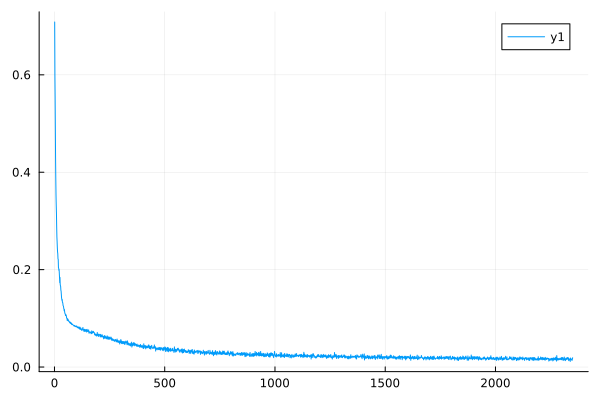

In [36]:
plot(l)

In [38]:
pc2 = phasor_model(x')

256×10 Matrix{Float32}:
  0.0102498     0.00807452   0.520903     …  -0.0641363   -0.0377044
  0.0237253    -0.0245015    0.0339786       -0.0110918   -0.00331114
 -0.00699099   -0.0129774    0.00794016      -0.003913    -0.0212282
  0.0108464    -0.0015386    0.00438318      -0.0317031   -0.0532206
  0.0114316    -0.00858105   0.0237839        0.521062     0.0133675
 -0.00953537    0.393547    -0.0600925    …   0.0724141   -0.0367776
  0.0168291    -0.0150869    0.475869         0.0472471   -0.0123226
 -0.042298     -0.0266066   -0.0169808       -0.0587303    0.0213695
  0.00706347    0.0145726    0.000750044     -0.010918     0.0415989
  0.0158202     0.0246055    0.0265914        0.0110289   -0.0500355
  ⋮                                       ⋱               
  0.0213264    -0.0307231    0.0342183        0.002573     0.00459318
 -0.0160223     0.0280303    0.0140104       -0.00389243  -0.027461
 -0.0319123    -0.0158148   -0.0315273        0.00925016   0.0436495
  0.0563419     0.3

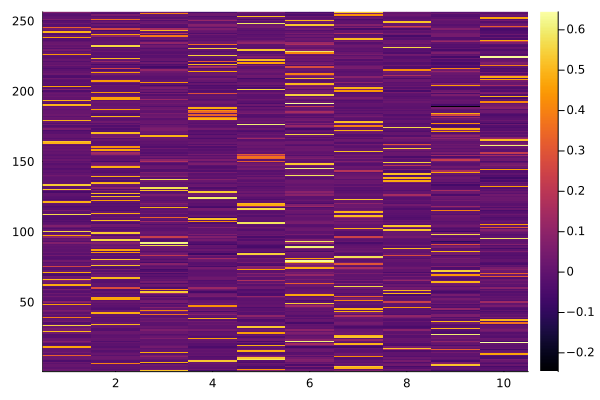

In [39]:
heatmap(pc2)

In [40]:
pc2 |> size

(256, 10)

In [43]:
pc2[1, :]

10-element Vector{Float32}:
  0.010249809
  0.008074517
  0.52090317
 -0.065969534
  0.06995404
  0.019216072
  0.06328174
 -0.0056714215
 -0.06413634
 -0.03770441

In [45]:
y[:,1]

10-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅

In [50]:
loss_and_accuracy(test_loader, phasor_model)

(0.016165774741772377, 0.9373)